In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV
from alpha_common_functions import lineplot
from sklearn.metrics import r2_score

from sklearn import set_config
set_config(display="diagram")

In [2]:
df = pd.read_csv("data/vehicles_v3.csv")

# Drop Columns
#### 1. title_status has least variance with almost 95% of them have 'clean' status. We will not be considering the feature in model fitting.
#### 2. 71% of records are missing size, we will thus be skipping them too.
#### 3. region has 404 distinct values, this we will only consider state for the prediction 

In [3]:
df.drop(columns=['title_status','size','region'], inplace=True)

# Train - Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1), df['price'], test_size = 0.3, random_state = 42)

# Answer check
print(X_train.shape)
print(X_test.shape)

(211026, 11)
(90440, 11)


# Pre Processing

![](images/PreProcessing.svg)

## Transformers

### cylinders - OrdinalEncoder
1. Similarly 15.61% od NaN will be lables as "other" and will combine with	0.24% of "other"
2. We will have total 7 unique categories
   Categories: [0.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0]
   unknown_category = 9
   missing_category = -1

In [5]:
categories_ = [[0.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0]]
unknown_categories_ = len(categories_[0])
missing_categories_ = -1

cylinders_ordinal_encoder = OrdinalEncoder(encoded_missing_value=missing_categories_, categories=categories_, unknown_value=unknown_categories_, handle_unknown='use_encoded_value')                                           

### condition - OrdinalEncoder
1. 35.44% of records have no condition provided. we will be putting all of them to new label "other"
2. We will have total 7 unique categories
   Categories: ["salvage", "fair", "good", "excellent","like new", "new"]
   unknown_category = 6
   missing_category = -1


In [6]:
categories_=[["salvage", "fair", "good", "excellent","like new", "new"]]
unknown_categories_ = len(categories_[0])
missing_categories_ = -1

condition_ordinal_encoder = OrdinalEncoder(encoded_missing_value=missing_categories_, categories=categories_, unknown_value=unknown_categories_, handle_unknown='use_encoded_value')                                           

### transmission - (SimpleImputer -> OneHotEncoder)
1. Only 0.33% of all records are null. We do have additional category of "other" which is 18%+. Thus we will add 0.33%  of null as "other"
2. This will narrow down the transmossion to just 3 subcategories
### fuel - (SimpleImputer -> OneHotEncoder)
1. 0.07% of nissing values will be combined with 7.88% of "others"
2. We will have total 5 unique categories
### type - (SimpleImputer -> OneHotEncoder)
1. 15.21 of NaN will be combined with 5.37% of Other
2. In Total 12 categories will be remaining
### drive - (SimpleImputer -> OneHotEncoder)
1. 26.31% of NaN will be renamed as "Others
2. Total remaining categories will be 4
### paint_color - (SimpleImputer -> OneHotEncoder)
1. 28.19% of NaN will be renamed as "Others
2. Total remaining categories will be 13

In [7]:
simple_imputer = SimpleImputer(strategy='constant', fill_value='other')

<div class="alert alert-block alert-success">
    <font size=6 color='black'>
        Model 7
    </font>
    <br>
    <font size=5 color='black'>
    <u>SequentialFeatureSelector</u>
    </font>
    <br>
    <font size=4 color='black'>
        1. ColumnTransformation<br>
        - OrdinalEncoder > PolynomialFeature (degree=2) on 'cylinders' and 'condition' on separate pipelines<br> 
        - SimpleImputer > OneHotEncoder on 'transmission','fuel', 'type', 'drive', 'paint_color' in a pipeline<br>
        - StandardScaler > PolynomialFeatures (degree=2) on ['year', 'odometer']<br>           
        2. SelectFromModel(Lasso)<br>
        3. LinearRegression<br>    
    </font>
    </p>
</div>

In [8]:
transformer = make_column_transformer(
    (Pipeline([
        ('simple_imputer', simple_imputer),
        ('one_hot_encoder', OneHotEncoder())
    ]),['transmission','fuel', 'type', 'drive', 'paint_color']),
    (OneHotEncoder(),['manufacturer','state']),
    (Pipeline([
        ('ordinal',cylinders_ordinal_encoder), 
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))]), ['cylinders']),     
    (Pipeline([
        ('ordinal',condition_ordinal_encoder), 
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))]), ['condition']),     
    (Pipeline([
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))
    ]) , ['year', 'odometer']),
    remainder='passthrough')

In [9]:
pipeline = Pipeline([('transformer', transformer),                                
                     ('selector', SelectFromModel(Lasso())),
                     ('linreg', LinearRegression())])

In [10]:
pipeline.fit(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['transmission', 'fuel',
                                                   'type', 'drive',
                                                   'paint_color']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'state']),
                                                 ('pipelin...
                                                                                  encoded_missing_value=-1,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=6)),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['condition']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])])),
                ('selector', SelectFromModel(estimator=Lasso())),
                ('linreg', LinearRegression())])

In [11]:
y_train_predict = pipeline.predict(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
y_test_predict = pipeline.predict(X_test[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
#predict on train and test
train_mses=(mean_squared_error(y_train, y_train_predict))
test_mses=(mean_squared_error(y_test, y_test_predict))

In [12]:
print(train_mses)
print(test_mses)

35465551.2312093
35327202.025824144


In [13]:
r2_score(y_test, y_test_predict)

0.7746256443907897

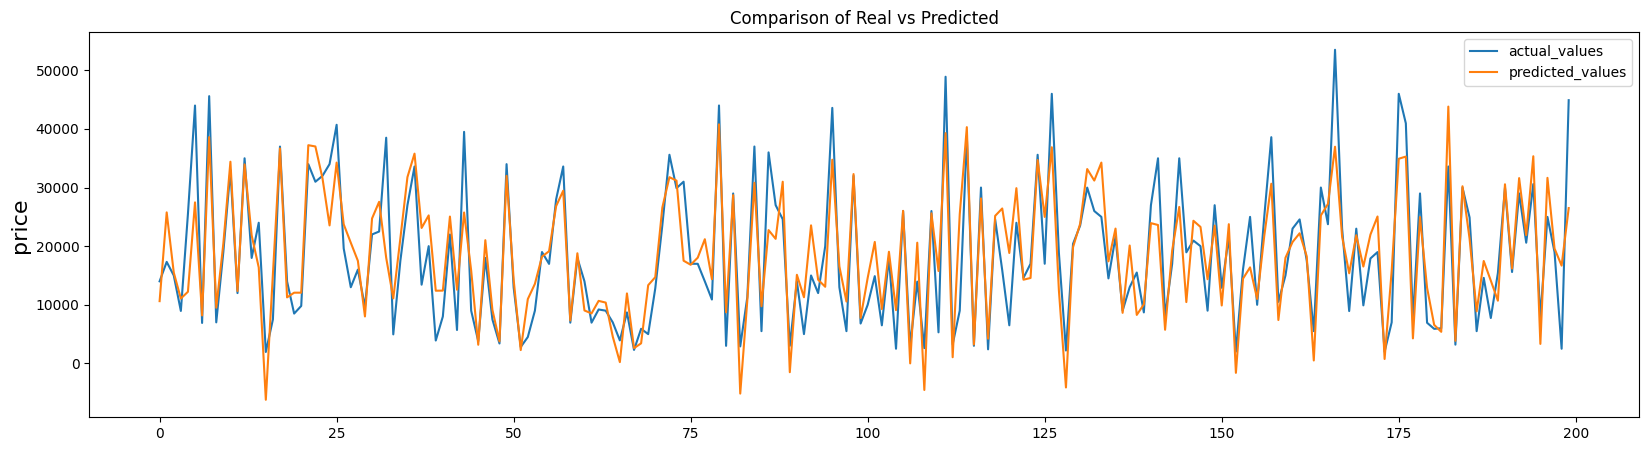

In [14]:
lineplot(y_test, y_test_predict, 200, "SelectFromModel_Lasso")

<div class="alert alert-block alert-success">
    <font size=6 color='black'>
        Model 8
    </font>
    <br>
    <font size=5 color='black'>
    <u>SequentialFeatureSelector</u>
    </font>
    <br>
    <font size=4 color='black'>
        1. ColumnTransformation<br>
        - OrdinalEncoder > PolynomialFeature (degree=2) on 'cylinders' and 'condition' on separate pipelines<br> 
        - SimpleImputer > OneHotEncoder on 'transmission','fuel', 'type', 'drive', 'paint_color' in a pipeline<br>
        - StandardScaler > PolynomialFeatures (degree=2) on ['year', 'odometer']<br>           
        2. Lasso<br>
    </font>
    </p>
</div>

In [15]:
pipeline = Pipeline([('transformer', transformer),  
                     ('lasso', Lasso(random_state = 42))])

In [16]:
pipeline.fit(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['transmission', 'fuel',
                                                   'type', 'drive',
                                                   'paint_color']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'state']),
                                                 ('pipelin...
                                                                                               'fair',
                                                                                               'good',
                                                                                               'excellent',
                                                                                               'like '
                                                                                               'new',
                                                                                               'new']],
                                                                                  encoded_missing_value=-1,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=6)),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['condition']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])])),
                ('lasso', Lasso(random_state=42))])

In [17]:
y_train_predict = pipeline.predict(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
y_test_predict = pipeline.predict(X_test[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
#predict on train and test
train_mses=(mean_squared_error(y_train, y_train_predict))
test_mses=(mean_squared_error(y_test, y_test_predict))

In [18]:
print(train_mses)
print(test_mses)

35481125.61269196
35351191.26094681


In [19]:
r2_score(y_test, y_test_predict)

0.7744726020297394

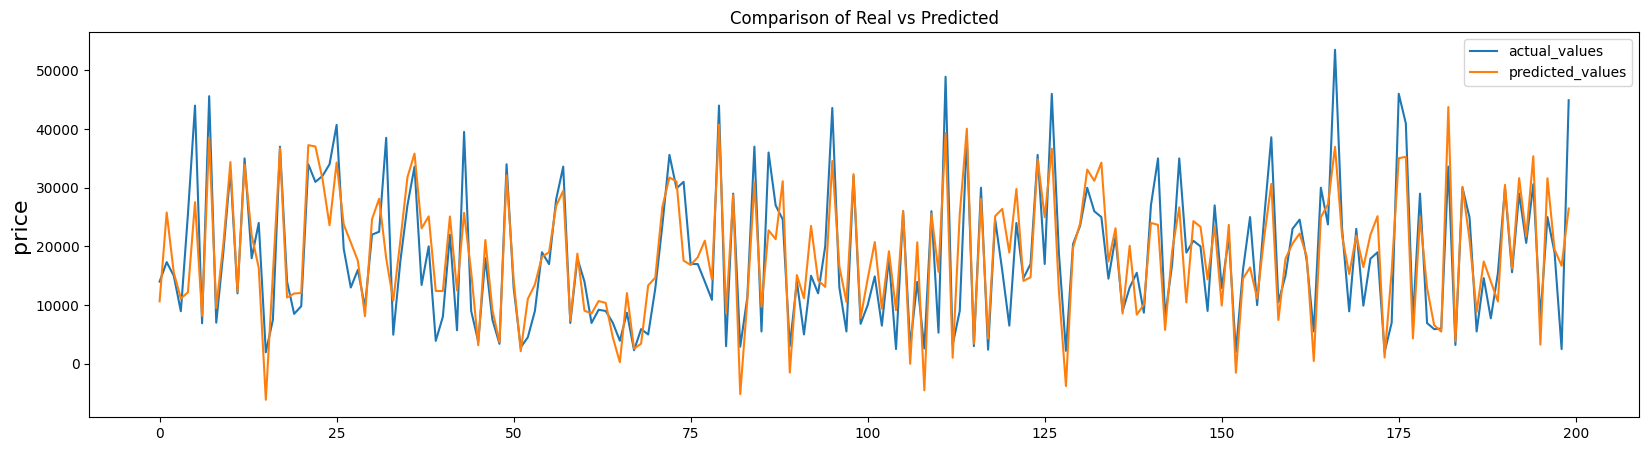

In [20]:
lineplot(y_test, y_test_predict, 200, "Lasso")

In [21]:
pipeline.named_steps['lasso'].coef_

array([-1.48440236e+03,  2.94635211e+02, -0.00000000e+00,  1.12987515e+04,
       -1.62711964e+03, -2.11837999e+02,  0.00000000e+00,  1.41042998e+03,
       -5.45084896e+02, -4.73790433e+03,  2.54469118e+03,  1.95667584e+03,
       -2.17755236e+03, -4.45337085e+02,  1.42852270e+03,  8.92216164e+02,
        3.04122954e+03, -1.50749317e+03,  3.91232722e+03, -0.00000000e+00,
       -1.00833466e+03,  2.73864415e+03, -1.32434190e+03, -8.01609663e+01,
        1.11058893e+03,  3.26374138e+02, -2.94511845e+02, -2.12721778e+02,
        0.00000000e+00,  3.02353138e+02, -5.77878070e+02, -4.19298546e+02,
       -2.43649177e+02,  0.00000000e+00,  5.69270889e+01, -4.71446099e+02,
        1.56412066e+02,  4.60947976e+02,  3.36601804e+02,  3.66382060e+03,
        0.00000000e+00,  3.56669424e+03,  1.33889495e+03, -1.84913681e+03,
        1.45931519e+03, -3.69095457e+02, -3.20178108e+03, -2.63886481e+03,
       -0.00000000e+00, -5.94893599e+03, -7.54298202e+02,  9.10480780e+02,
       -2.56264573e+03,  

<div class="alert alert-block alert-success">
    <font size=6 color='black'>
        Model 9
    </font>
    <br>
    <font size=5 color='black'>
    <u>SequentialFeatureSelector</u>
    </font>
    <br>
    <font size=4 color='black'>
        1. ColumnTransformation<br>
        - OrdinalEncoder > PolynomialFeature (degree=2) on 'cylinders' and 'condition' on separate pipelines<br> 
        - SimpleImputer > OneHotEncoder on 'transmission','fuel', 'type', 'drive', 'paint_color' in a pipeline<br>
        - StandardScaler > PolynomialFeatures (degree=2) on ['year', 'odometer']<br>           
        2. SelectFromModel(Lasso) max_features=75 <br>
        3. LinearRegression<br>    
    </font>
    </p>
</div>

In [22]:
pipeline = Pipeline([('transformer', transformer),                                
                     ('selector', SelectFromModel(Lasso(), max_features=75)),
                     ('linreg', LinearRegression())])

In [23]:
pipeline.fit(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['transmission', 'fuel',
                                                   'type', 'drive',
                                                   'paint_color']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'state']),
                                                 ('pipelin...
                                                                                  encoded_missing_value=-1,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=6)),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['condition']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])])),
                ('selector',
                 SelectFromModel(estimator=Lasso(), max_features=75)),
                ('linreg', LinearRegression())])

In [24]:
y_train_predict = pipeline.predict(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
y_test_predict = pipeline.predict(X_test[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
#predict on train and test
train_mses=(mean_squared_error(y_train, y_train_predict))
test_mses=(mean_squared_error(y_test, y_test_predict))

In [25]:
print(train_mses)
print(test_mses)

35864312.200730674
35748186.65240281


In [26]:
r2_score(y_test, y_test_predict)

0.771939919694359

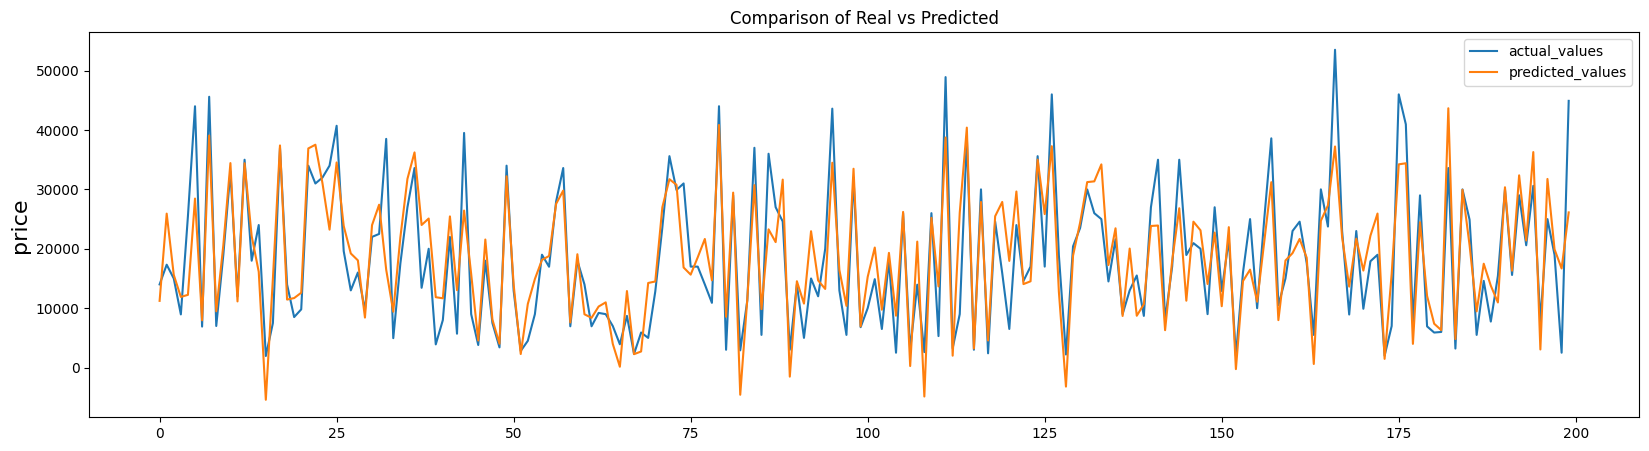

In [27]:
lineplot(y_test, y_test_predict, 200, "SelectFromModel_Lasso_75")

In [28]:
all_features_names = pipeline.named_steps['transformer'].get_feature_names_out()
len(all_features_names)

139

In [29]:
selected_features_mask = pipeline.named_steps['selector'].get_support()

In [30]:
selected_feature_names = [name for name, selected in zip(all_features_names, selected_features_mask) if selected]
selected_feature_names

['pipeline-1__transmission_automatic',
 'pipeline-1__fuel_diesel',
 'pipeline-1__fuel_electric',
 'pipeline-1__fuel_other',
 'pipeline-1__type_SUV',
 'pipeline-1__type_bus',
 'pipeline-1__type_convertible',
 'pipeline-1__type_coupe',
 'pipeline-1__type_hatchback',
 'pipeline-1__type_offroad',
 'pipeline-1__type_other',
 'pipeline-1__type_pickup',
 'pipeline-1__type_sedan',
 'pipeline-1__type_truck',
 'pipeline-1__type_wagon',
 'pipeline-1__drive_4wd',
 'pipeline-1__drive_fwd',
 'pipeline-1__drive_rwd',
 'pipeline-1__paint_color_grey',
 'onehotencoder__manufacturer_Alfa-Romeo',
 'onehotencoder__manufacturer_Audi',
 'onehotencoder__manufacturer_Bmw',
 'onehotencoder__manufacturer_Buick',
 'onehotencoder__manufacturer_Cadillac',
 'onehotencoder__manufacturer_Chrysler',
 'onehotencoder__manufacturer_Dodge',
 'onehotencoder__manufacturer_Fiat',
 'onehotencoder__manufacturer_Ford',
 'onehotencoder__manufacturer_Gmc',
 'onehotencoder__manufacturer_Harley-Davidson',
 'onehotencoder__manufactur

<div class="alert alert-block alert-warning">
    <font size=5, color='black'>
        Model 9
    </font>
    <br>
    <font size=4 color='black'>
    <u> Feature count: 30 </u><br>
    </font>
    <font size=3 color='black'>
    * SelectFromModel with Lasso estimator with approx. 1/2 the features after transform yields approx same result as with all fields.<br>
    </font>
</div>